In [1]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pwd

import os


# /content/drive/MyDrive/Colab Notebooks/PIDOC/vanderPol
path = '/content/drive/MyDrive/Colab Notebooks/PIDOC/vanderPol'

os.chdir(path)

!pwd




os.listdir(path)

# Commented out IPython magic to ensure Python compatibility.



/content
/content/drive/MyDrive/Colab Notebooks/PIDOC/vanderPol


['data_generation.py',
 'train_10.mat',
 'run_vdP_mu=3.py',
 'run_vdP_mu=5.py',
 'benchmark_main.py',
 'prediction.txt',
 'benchmark_main.ipynb',
 'trainingResult_mu9_epoch200.png',
 'trainingResult_mu9_epoch300.png',
 'trainingResult_mu9_epoch250.png']

In [3]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

%matplotlib inline


TensorFlow 1.x selected.
1.15.2


In [4]:
# import tensorflow as tf
# import deepxde as dde
import numpy as np
from scipy import linspace
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scipy.io
import time
import timeit

# from mpi4py import MPI
# import tensorflow_probability as tfp

# tf.disable_v2_behavior()
print(tf.__version__)



1.15.2


# 定义模型

In [5]:
steps = 0

class DeepvdP:
    # Initialize the class
    def __init__(self, x, t, layers, lbfs_loops):
        
        self.lbfs_loops = lbfs_loops 

        self.lb = t.min(0)
        self.ub = t.max(0)
        
        self.x = x
        self.t = t
        
        self.layers = layers
        
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        
        # 这里是控制目标x和x的导数========期望控制目标轨迹
        self.x_control = 2 * tf.math.sin(self.t_tf)#5.00 *
        self.x_d_control = 2 * tf.math.cos(self.t_tf)
        self.x_dd_control = - 2 * tf.math.sin(self.t_tf) #5.00 *

        self.x_pred, self.x_d_pred, self.x_dd_pred, self.ICs = self.vdP(self.t_tf)

        # 控制信号和二阶导数都是sin函数
        self.x_res = self.x_control - self.x_pred
        self.x_d_res = self.x_d_control - self.x_d_pred
        self.x_dd_res = self.x_dd_control - self.x_dd_pred

        # =========讨论：残差如何添加进去=======================
        # ===============================================================
        # self.control = self.x_res 
        # self.control = self.x_d_res
        # self.control = self.x_dd_res
        # self.control = self.x_res + self.x_d_res 
        self.control = self.x_res + self.x_dd_res  # 方式1：原论文

        self.loss_ics = tf.reduce_sum(tf.square(self.ICs))

        self.loss_x_res = tf.reduce_sum(tf.square(self.x_res))
        self.loss_x_dd_res = tf.reduce_sum(tf.square(self.x_dd_res))

        self.loss_xtrue_xcontrol = 1*tf.reduce_sum(tf.square( self.x_tf - (self.x_control) ))

        self.loss_control = tf.reduce_sum(tf.square(self.control))  # 残差1：原论文的残差损失

        # self.loss_control = self.loss_x_res + self.loss_x_dd_res # 残差2：my残差损失
        # self.loss_control = tf.reduce_sum(tf.square(self.x_res)) + tf.reduce_sum(tf.square(self.x_dd_res))

        self.loss_data = 1*tf.reduce_sum(tf.square( self.x_tf - (self.x_pred) ))
        
        # self.loss = 1 * tf.reduce_sum(tf.square(self.control)) + tf.reduce_sum(tf.square(self.ICs)) + \
        # tf.reduce_sum(tf.square( self.x_tf - (self.x_pred) )) 

        self.loss =  self.loss_control +  self.loss_ics + self.loss_data + self.loss_xtrue_xcontrol

        self.loss_list = [] 
        self.loss_control_list = [] 
        self.loss_ics_list = []
        self.loss_data_list = []

          
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                      method = 'L-BFGS-B', 
                                      options = {'maxiter': self.lbfs_loops,
                                                  'maxfun': self.lbfs_loops,
                                                  'maxcor': 50,
                                                  'maxls': 50,
                                                  'ftol' : 1.0 * np.finfo(float).eps}) 


        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

# ==============================================================================================
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
   
    def neural_net(self, t, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
# ==============================================================================================
    def vdP(self, t):
      x = self.neural_net(tf.concat([t],1), self.weights, self.biases)
      # dx_t = dde.grad.jacobian(x, t, i=0)
      # dx_tt = dde.grad.hessian(x, t, i=0)
      dx_t = tf.compat.v1.gradients(x, t)
      dx_tt = tf.compat.v1.gradients(dx_t, t)

      # x_desire = tf.math.sin(t) #5 * 
      # x_dot_desire = tf.math.cos(t) #5 * 
      # x_ddot_desire = - tf.math.sin(t) #-5 * 
      # control = (x_desire - x) + (x_ddot_desire - dx_tt)

      ICs = x[0] - 1# Initial condition: 1, 5, 10
      return x, dx_t, dx_tt, ICs

# ==============================================================================================
    def callback(self, loss, control, ics, data): #, betta
        #print('It: %d, log Loss: %e, loss_x: %e, loss_y: %e, loss_z: %e, loss_f_x: %e, loss_f_y: %e, loss_f_z: %e,loss_lambda_x: %e, loss_lambda_y: %e, loss_lambda_z: %e,log loss_val: %e' %
        # (step, loss, loss_x, loss_y, loss_z, loss_f_x, loss_f_y, loss_f_z, loss_lambda_x, loss_lambda_y, loss_lambda_z, loss_val))
        global steps
        steps += 1
        if steps % 10 == 0:
          print('It: %d, loss_total: %.3e, loss_control: %.3e, loss_ics: %.3e, loss_data: %.3e' % (steps, loss, control, ics, data)) #, betta B: %.5f

          self.loss_list.append(loss)
          self.loss_control_list.append(control)
          self.loss_ics_list.append(ics)
          self.loss_data_list.append(data)

    def train(self, nIter): 

        # 定义数据存储
        tf_dict = {self.x_tf: self.x, self.t_tf: self.t}

        # var_loss = tf.Variable(tf_dict)
        # loss = lambda: (var_loss ** 2)/2.0
        
        # print('Adam starts') 
        # for it_Adam in range(nIter):
        #   self.sess.run(self.train_op_Adam, feed_dict = tf_dict)

        #   if it_Adam % 10 == 0:
        #     loss, control, ics, data = self.sess.run([self.loss, self.loss_control, self.loss_ics, self.loss_data], feed_dict = tf_dict)
        #     print('It: %d, loss_total: %.3e, loss_control: %.3e, loss_ics: %.3e, loss_data: %.3e' % (it_Adam, loss, control, ics, data)) #, betta B: %.5f

        #     self.loss_list.append(loss)
        #     self.loss_control_list.append(control)
        #     self.loss_ics_list.append(ics)
        #     self.loss_data_list.append(data)

        print('L-BFGS-B starts')
        self.optimizer.minimize(self.sess,
                    feed_dict = tf_dict,
                    fetches = [self.loss, self.loss_control, self.loss_ics, self.loss_data],
                    loss_callback = self.callback)

        # self.optimizer.minimize(self.loss)
        # self.optimizer.minimize(self.loss, global_step=None, var_list=var_loss,
    # aggregation_method=None, colocate_gradients_with_ops=False, name=None,
    # grad_loss=None)

        # (self.sess, feed_dict = tf_dict, fetches = [self.loss], loss_callback = self.callback)
            
# ==============================================================================================    
    def predict(self, t_star):
        
        tf_dict = {self.x_tf: self.x, self.t_tf: self.t}  
        x_star = self.sess.run(self.x_pred, tf_dict)
        
        return x_star



# 修改-加载数据

In [6]:
# if __name__ == "__main__": 


layers = [1, 60, 60, 60, 60, 60, 60, 1]
# layers = [1, 30, 30, 30, 30, 30, 30, 1]#30, 30, 30, 30, \
            #  30, 30, 30, 30, 30, 30, 30, 30, 30, 30, \
            #  30, 30, 30, 30, 30, 30, 30, 30, 30, 30, \
            #  30, 30, 30, 30, 30, 30, 30, 30, 30, 30, \
            #  30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 
# Set NN Structure

# PINC_mu3
# PINC_mu5
# PINC_mu9

# data = scipy.io.loadmat('../data/train.mat') # 基准数据

data = scipy.io.loadmat('../data/PINC_mu9.mat')


data

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Sat Dec 18 19:12:06 2021',
 '__version__': '1.0',
 't': array([[0.00000000e+00],
        [1.00033344e-02],
        [2.00066689e-02],
        ...,
        [2.99799933e+01],
        [2.99899967e+01],
        [3.00000000e+01]]),
 'x': array([[1.        ],
        [0.99994981],
        [0.99979972],
        ...,
        [1.81987143],
        [1.8189998 ],
        [1.81812741]]),
 'xdot': array([[ 0.        ],
        [-0.01000319],
        [-0.0200057 ],
        ...,
        [-0.08709497],
        [-0.08717163],
        [-0.0872485 ]])}

# 训练数据

In [7]:

t_obtain = data['t'] # 
X_obtain = data['x'] # 

print('数据量为：', t_obtain.shape)

t_star = t_obtain[0:3000]
# t_star = t_star 
X_star = X_obtain[0:3000]

print('训练数据维度为：', t_star.shape)


# Training Data    
x_train = X_star #x[:,:] # [idx,:]
# noise = 0.00
# x_train = x_train * (1 + noise*np.random.standard_normal(3000))
t_train = t_star #t[:,:]



数据量为： (3000, 1)
训练数据维度为： (3000, 1)


# 训练数据图像

Text(0.5, 1.0, 'training data')

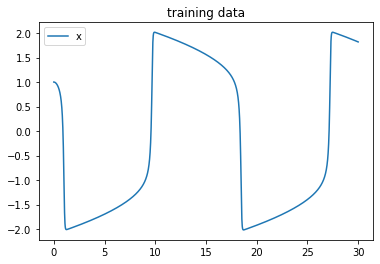

In [8]:
fig = plt.figure()

plt.plot(t_star, X_star)
# plt.plot(t_star, x_pred)

plt.legend('x_true')
plt.title('training data')



# 原始信号和控制信号图像

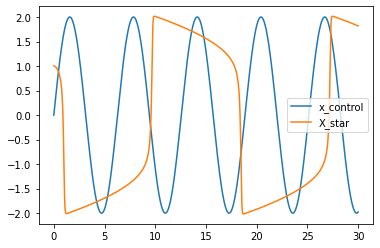

In [9]:
x_control = 2 * np.sin(t_star)

fig = plt.figure()

plt.plot(t_star, x_control)
plt.plot(t_star, X_star)

plt.legend(('x_control', 'X_star'))
# plt.title('training result')


# 修改-开始训练

In [10]:

# Training
t_tic = time.time()

lbfs_loops = int(150) 
model = DeepvdP(x_train, t_train, layers, lbfs_loops)
model.train(10)
# cpu_time = timeit.default_timer()


# Prediction
x_pred = model.predict(t_star)
# loss_hist = model.callback()
elapsed_toc = time.time() - t_tic

np.savetxt("prediction.txt", np.hstack(x_pred))
print(elapsed_toc)


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

L-BFGS-B starts
It: 10, loss_total: 2.469e+04, loss_control: 1.140e+02, loss_ics: 1.928e+00, loss_data: 7.575e+03
It: 20, loss_total: 5.055e+04, loss_control: 1.502e+04, loss_ics: 1.844e+01, loss_data: 1.852e+04
It: 30, loss_total: 2.466e+04, loss_control: 1.611e+02, loss_ics: 2.362e+00, loss_data: 7.504e+03
It: 40, loss_total: 2.604e+04, los

# 训练误差

Text(0.5, 1.0, 'training loss')

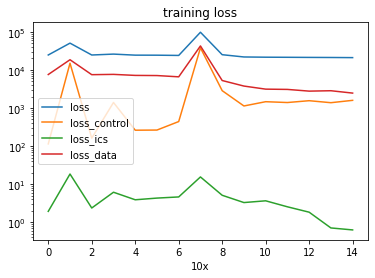

In [11]:
# 画训练误差图像
# fig = plt.figure()
# plt.plot(loss_x_history_Adam_Pretrain)
# plt.plot(loss_y_history_Adam_Pretrain)
# plt.plot(loss_z_history_Adam_Pretrain)
# plt.yscale('log')
# plt.xlabel('10x')
# plt.legend(('loss_x', 'loss_y', 'loss_z'))
# plt.title('loss_x and loss_y history of Adam(Pretraining)')
# plt.savefig('2.png')

loss = model.loss_list

loss_control = model.loss_control_list

loss_ics = model.loss_ics_list

loss_data = model.loss_data_list

fig = plt.figure()
plt.plot(loss)
plt.plot(loss_control)
plt.plot(loss_ics)
plt.plot(loss_data)

plt.xlabel('10x')

plt.yscale('log')

plt.legend(('loss', 'loss_control', 'loss_ics', 'loss_data'))
plt.title('training loss')



# 训练结果图像

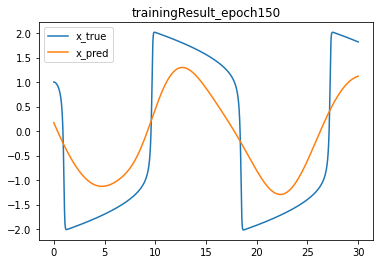

In [12]:
# 画训练测试结果

# t_obtain = data['t'] # 
# X_obtain = data['x'] # 
# t_star = t_obtain[0:3000]
# # t_star = t_star 
# X_star = X_obtain[0:3000]

# x_pred = model.predict(t_star)


fig = plt.figure()

plt.plot(t_star, X_star)
plt.plot(t_star, x_pred)

plt.legend(('x_true', 'x_pred'))
plt.title('trainingResult_epoch150')
plt.savefig('trainingResult_mu9_epoch150.png')


# 控制效果和控制目标的比较

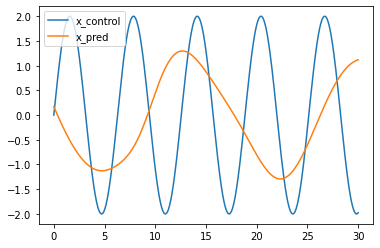

In [13]:


fig = plt.figure()

plt.plot(t_star, x_control)
plt.plot(t_star, x_pred)

plt.legend(('x_control', 'x_pred'))
# plt.title('training result')



# 控制信号的相位图

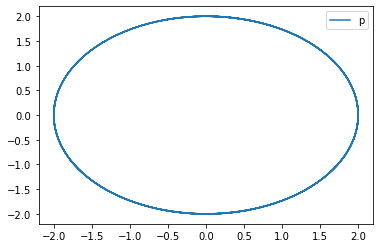

In [14]:

x_control = 2 * np.sin(t_star)

x_control_d = 2 * np.cos(t_star)


fig = plt.figure()
plt.plot(x_control, x_control_d)
plt.legend('phase_x')
plt.show()

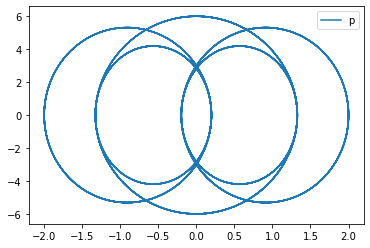

In [15]:


x_control_freq = np.sin(t_star) +  np.sin(5*t_star)

x_control_d_freq = np.cos(t_star) + 5*np.cos(5*t_star)


fig = plt.figure()
plt.plot(x_control_freq, x_control_d_freq)
plt.legend('phase_x_freq')
plt.show()

